<a href="https://colab.research.google.com/github/mahasvinreddy07/ML_Lab/blob/main/Lab_3_AP23110010075(Feature_Engineering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [ ]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [ ]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [ ]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [ ]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [ ]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [ ]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


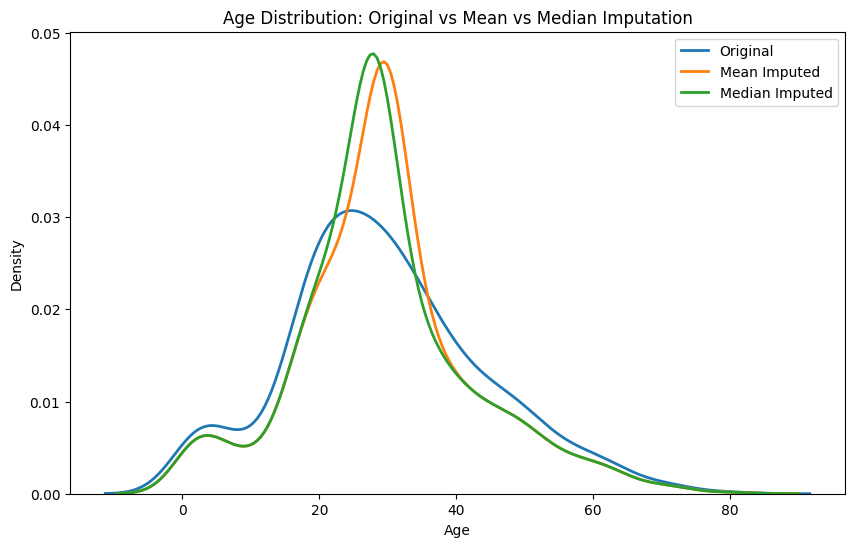

KS Test - Mean: KstestResult(statistic=np.float64(0.10683869507398919), pvalue=np.float64(0.00021167422560980736), statistic_location=np.float64(29.0), statistic_sign=np.int8(1))
KS Test - Median: KstestResult(statistic=np.float64(0.0979354704844901), pvalue=np.float64(0.0009089324524751338), statistic_location=np.float64(28.0), statistic_sign=np.int8(-1))
Wasserstein Distance - Mean: 2.2493391375167606
Wasserstein Distance - Median: 2.235496750888907


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, wasserstein_distance

# Original (drop NaN for fair comparison)
age_original = df['Age'].dropna()

# Mean imputation
age_mean = df['Age'].fillna(df['Age'].mean())

# Median imputation
age_median = df['Age'].fillna(df['Age'].median())

# ==== Plot distributions ====
plt.figure(figsize=(10,6))
sns.kdeplot(age_original, label="Original", linewidth=2)
sns.kdeplot(age_mean, label="Mean Imputed", linewidth=2)
sns.kdeplot(age_median, label="Median Imputed", linewidth=2)
plt.title("Age Distribution: Original vs Mean vs Median Imputation")
plt.legend()
plt.show()

# ==== Statistical comparison ====
# KS Test
ks_mean = ks_2samp(age_original, age_mean)
ks_median = ks_2samp(age_original, age_median)

# Wasserstein distance
w_mean = wasserstein_distance(age_original, age_mean)
w_median = wasserstein_distance(age_original, age_median)

print("KS Test - Mean:", ks_mean)
print("KS Test - Median:", ks_median)
print("Wasserstein Distance - Mean:", w_mean)
print("Wasserstein Distance - Median:", w_median)


In [ ]:
# Make a copy of df
df_imp = df.copy()

# ---- 2) Fill Embarked with 'Unknown' ----
df_unknown = df_imp.copy()
df_unknown['Embarked'] = df_unknown['Embarked'].fillna('Unknown')

# ---- 1) Fill Embarked with mode ----
df_mode = df_imp.copy()
df_mode['Embarked'] = df_mode['Embarked'].fillna(df_mode['Embarked'].mode()[0])

# ---- Compare results ----

print("Unknown imputation value_counts():")
print(df_unknown['Embarked'].value_counts(),"\n")

print("Mode imputation value_counts():")
print(df_mode['Embarked'].value_counts())


Unknown imputation value_counts():
Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64 

Mode imputation value_counts():
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [ ]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

Answers -

1.according to the graph i think mean is a lot closer to the orignal representation (I still don't understand the difference on how we are testing)

2.After the mode imputation S increased by 2 as there were 2 Nan values that were not counted in the unknown imputation


## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

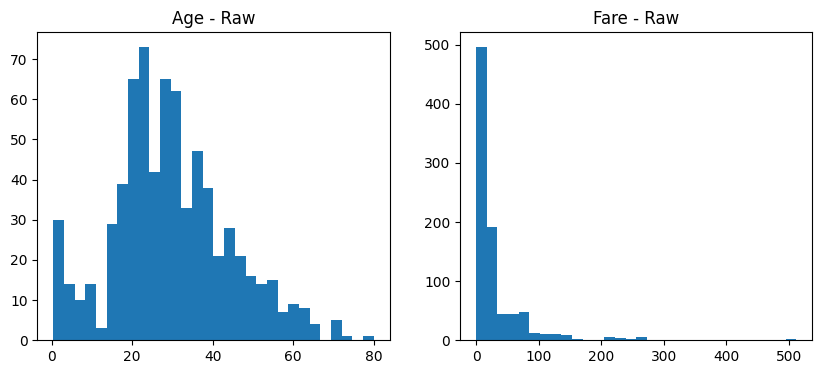

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

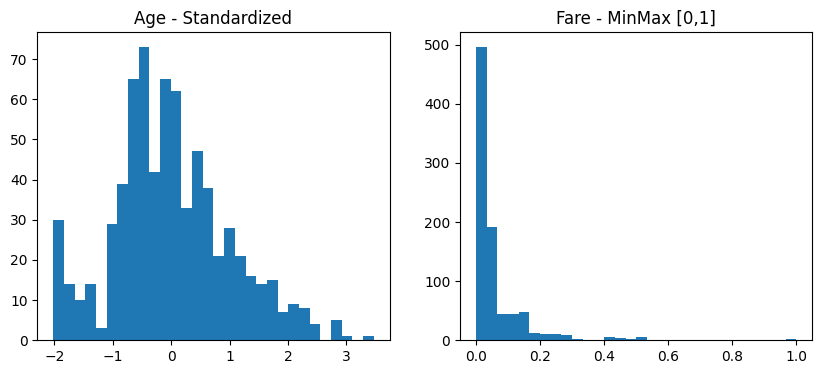

In [ ]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

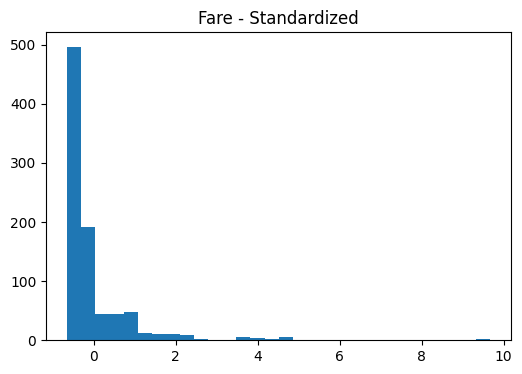

In [ ]:
sc_mn  = StandardScaler()
fare_mn = sc_mn.fit_transform(df_imp[['Fare']].values)

plt.figure(figsize=(6,4))
plt.hist(fare_mn.flatten(), bins=30)
plt.title('Fare - Standardized')
plt.show()

In [ ]:
from sklearn.preprocessing import Normalizer
import pandas as pd

# Select Age and Fare columns (drop NaNs first)
df_sub = df_imp[['Age', 'Fare']].dropna()

# Apply Normalizer (row-wise L2 normalization)
normalizer = Normalizer()
normalized = normalizer.fit_transform(df_sub)

# Put back into DataFrame
normalized_df = pd.DataFrame(normalized, columns=['Age_norm', 'Fare_norm'])

# Show first 5 normalized vectors
print(normalized_df.head())


   Age_norm  Fare_norm
0  0.949757   0.312988
1  0.470417   0.882444
2  0.956551   0.291564
3  0.550338   0.834942
4  0.974555   0.224148


**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [ ]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [ ]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# Select Embarked column
embarked = df_imp[['Embarked']]

# ---- Ordinal Encoding ----
ord_enc = OrdinalEncoder()
ord_vals = ord_enc.fit_transform(embarked)
ord_df = pd.DataFrame(ord_vals, columns=['Embarked_ord'])

print("Ordinal Encoding features:", ord_df.shape[1])  # should be 1

# ---- One-Hot Encoding ----
ohe_df = pd.get_dummies(embarked, prefix='Embarked')

print("One-Hot Encoding features:", ohe_df.shape[1])  # number of unique categories

# Optional: print the actual encoded DataFrames head
print("\nOrdinal Encoding (head):")
print(ord_df.head())

print("\nOne-Hot Encoding (head):")
print(ohe_df.head())


Ordinal Encoding features: 1
One-Hot Encoding features: 3

Ordinal Encoding (head):
   Embarked_ord
0           2.0
1           0.0
2           2.0
3           2.0
4           2.0

One-Hot Encoding (head):
   Embarked_C  Embarked_Q  Embarked_S
0       False       False        True
1        True       False       False
2       False       False        True
3       False       False        True
4       False       False        True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

I think one-hot is safer for linear models because it categorizes them not in order hence there might be no "false ordering" and each category gets its own weight

## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

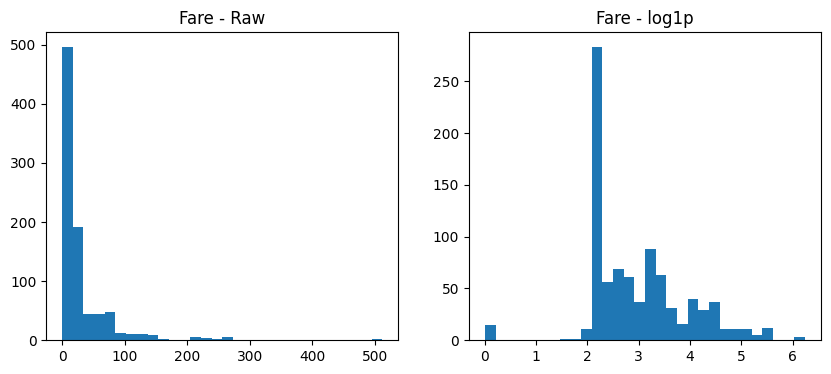

In [ ]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

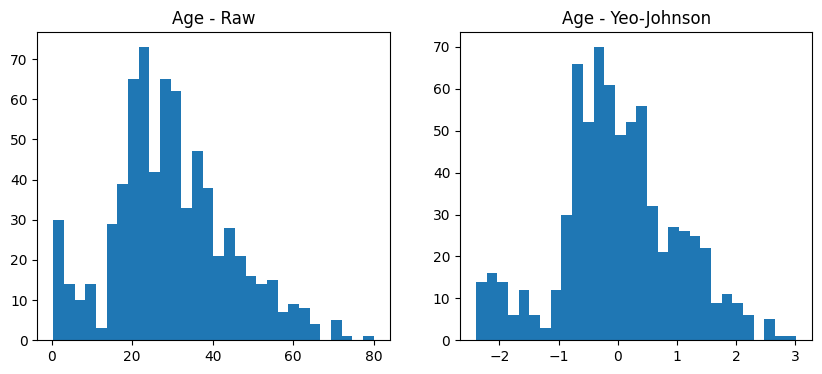

In [ ]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [ ]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (714, 2)  -> With poly: (714, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

Skewness: 4.787316519674893


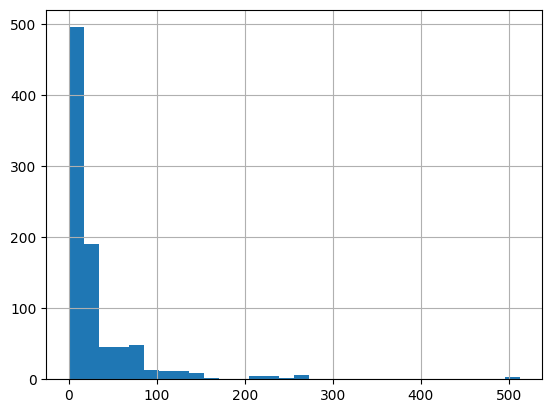

In [ ]:
df_imp['Fare'].hist(bins=30)
print("Skewness:", df_imp['Fare'].skew())


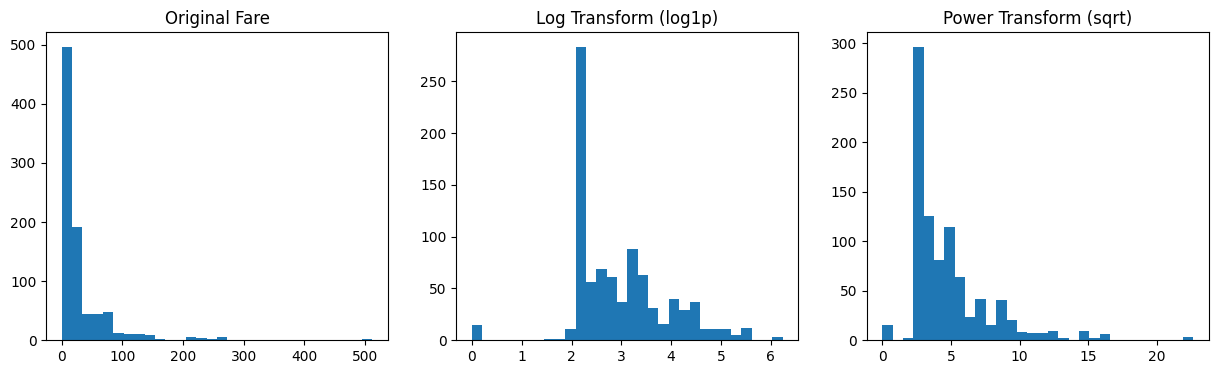

Skewness Original: 4.787316519674893
Skewness Log: 0.3949280095189306
Skewness Sqrt: 2.08500441820235


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fare = df_imp['Fare']

# Transformations
fare_log = np.log1p(fare)   # log(1 + x)
fare_sqrt = np.sqrt(fare)   # power transform (square root)

# Plot original vs transforms
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].hist(fare, bins=30)
axes[0].set_title("Original Fare")

axes[1].hist(fare_log, bins=30)
axes[1].set_title("Log Transform (log1p)")

axes[2].hist(fare_sqrt, bins=30)
axes[2].set_title("Power Transform (sqrt)")

plt.show()

print("Skewness Original:", fare.skew())
print("Skewness Log:", fare_log.skew())
print("Skewness Sqrt:", fare_sqrt.skew())


**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

Answer:

(2)

All original features

All squared terms

All interaction terms (products of features)

## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.95704763 0.03994637]


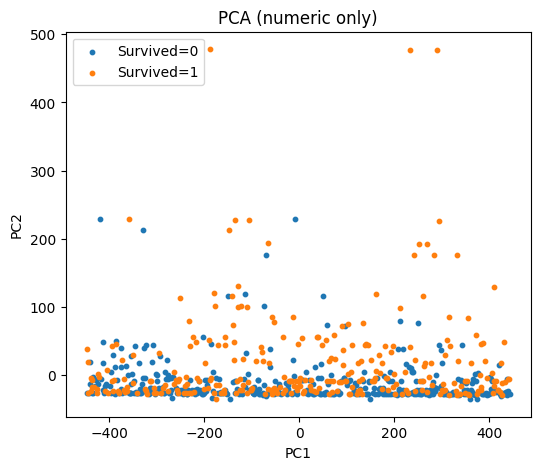

In [ ]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

In [ ]:
#1)
# Variance of each numeric column
variances = df_imp.select_dtypes(include=['number']).var().sort_values(ascending=False)
print(variances)

# Top 2 columns
print("\nTop 2 contributors to variance:")
print(variances.head(2))


PassengerId    66231.000000
Fare            2469.436846
Age              211.019125
SibSp              1.216043
Pclass             0.699015
Parch              0.649728
Survived           0.236772
dtype: float64

Top 2 contributors to variance:
PassengerId    66231.000000
Fare            2469.436846
dtype: float64


In [ ]:
#2)

pca3 = PCA(n_components=3, random_state=42)
Z3 = pca3.fit_transform(num_only.values)

print("Explained variance ratios (3 PCs):", pca3.explained_variance_ratio_)
print("Cumulative explained variance:", pca3.explained_variance_ratio_.cumsum())


Explained variance ratios (3 PCs): [0.95704763 0.03994637 0.00297671]
Cumulative explained variance: [0.95704763 0.996994   0.99997071]


**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

In [ ]:
df_prep = df.copy()

# Impute
df_prep['Age'] = df_prep['Age'].fillna(df_prep['Age'].median())
df_prep['Embarked'] = df_prep['Embarked'].fillna(df_prep['Embarked'].mode()[0])
df_prep['Cabin'] = df_prep['Cabin'].fillna('Unknown')


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc_age = StandardScaler()
df_prep['Age_std'] = sc_age.fit_transform(df_prep[['Age']])

mm_fare = MinMaxScaler()
df_prep['Fare_mm'] = mm_fare.fit_transform(df_prep[['Fare']])


In [ ]:
df_prep = pd.get_dummies(df_prep, columns=['Sex','Embarked'], drop_first=False)


In [ ]:
import numpy as np

df_prep['Fare_log'] = np.log1p(df_prep['Fare'])


In [ ]:
from sklearn.decomposition import PCA

num_cols = df_prep.select_dtypes(include=['number']).dropna(axis=0)
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_cols.values)


Q1. Which step changed the data distribution the most?

Fare is highly skewed (a few very rich passengers with extreme ticket prices).

biggest change = log1p(Fare)

Q2. Which encoding produced more features, ordinal or one-hot? Why?

ordinal creates 1 column
one-hot creates 3 columns

one-hot is safer because it doesn’t imply a false order between categories

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Select features
X = df_prep[['Age_std','Fare_mm','Fare_log'] +
            [col for col in df_prep.columns if col.startswith('Sex_') or col.startswith('Embarked_')]]
y = df_prep['Survived']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Model
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Accuracy
acc = accuracy_score(y_test, clf.predict(X_test))
print("Logistic Regression Accuracy:", acc)


Logistic Regression Accuracy: 0.7757847533632287


## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).